# A practice toy proyect to solving linear differential equations using Hybrid Classical-Quantum algorithms.

# Based on arXiv:2011.10395v2 to be done in Qiskit.

In [1]:
# Initialisation in Python

import numpy as np # Python library used for working with arrays.
from numpy import pi # Value of pi.
import matplotlib.pyplot as plt # Library for data visualization (plots and others). Alternative to MATLAB.
from scipy.integrate import odeint # Collection of numerical algorithms to solve ordinary differential equations. 
import random # Generate random numbers.

In [2]:
# Quantum computing library initialisation: Qiskit (Vendor: IBM)

from qiskit import * # Imports all the functions and classes.
from qiskit import BasicAer # Give access some of the basic simulators.
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter, QuantumRegister, ClassicalRegister
# Define a quantum circuit,quickly generate lists of parameters, define a register of qubits and the classical analog.
from qiskit.circuit.library import PauliFeatureMap # Feature maps already in Qiskit. Just to test.
from qiskit.circuit.library import EfficientSU2
# Circuit with layers of single qubit operations spanned by SU(2). It can be used to prepare trial wave functions for VQA.
from qiskit.algorithms.optimizers import ADAM # Adam is a gradient-based optimization algorithm.
# According to the documentation "numerical optimization method for problems where the derivative of the function is not known".
from qiskit.utils import QuantumInstance # It "holds a backend as well as configuration for circuit transpilation and execution".
from qiskit.utils import algorithm_globals # Just in case. Most include the optimizers.
from qiskit.visualization import circuit_drawer # As the name say.
from qiskit.opflow import X, Y, Z, I, StateFn, CircuitStateFn, PauliExpectation
# "Operators and State functions are the building blocks of Quantum Algorithms"
from qiskit.opflow.gradients import Gradient# A very use way to minnimize functions is using gradients.


num_qubits = 2 # 2 qubits.

In [3]:
# Initialisation: ML with Qiskit

from qiskit_machine_learning.kernels import QuantumKernel # "It calculates a kernel matrix, given datapoints x and y and feature map..."
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer #  To train the kernel parameters on the dataset.
from qiskit_machine_learning.datasets import ad_hoc_data # Just in case. Generates a toy dataset that can be fully separated with ZZ_Feature_Map.
from qiskit_machine_learning.neural_networks import OpflowQNN # Opflow Quantum Neural Network.

from qiskit.providers.aer import AerSimulator # Just in case. Variety of simulation methods.

# We will try to implement the model for the simple differential equation:

$\dfrac{df(x)}{dx} = -kf(x) $,

with parameter $k=0.3$ and the initial condition $f_{0}=5$.

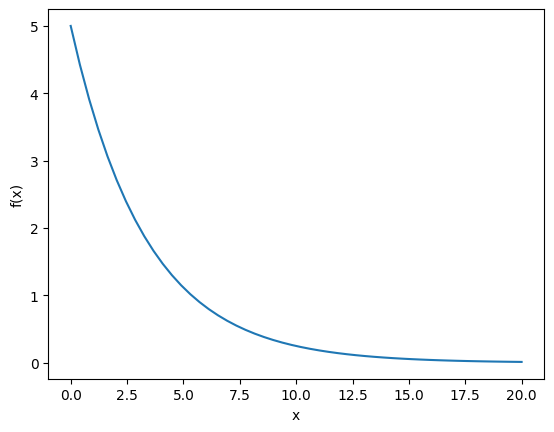

In [11]:
# Differential equation parameters

from scipy.integrate import odeint

def model(f,x): # Function that returns df/dx
    k = 0.3
    dfdx = -k * f
    return dfdx

x = np.linspace(0, 20) # X points in the domain
f0 = 5 # Initial condition
sol = odeint(model, f0, x)

# Exact DE solution - for checking after
def f(x):
    return -k*(x**2)/2

# Traditional plot
plt.plot(x,sol)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [12]:
number_grid = 10  # Number of grid points of the discretized differential equation - trainning   
range_min = 0 # Minimum of the interval on which the function lives.
range_max = 20 # Maximum of the interval on which the function lives.
TrialX = np.linspace(range_min, range_max, number_grid) # Optimisation grid

print(TrialX)

[ 0.          2.22222222  4.44444444  6.66666667  8.88888889 11.11111111
 13.33333333 15.55555556 17.77777778 20.        ]


In [13]:
number_grid = 50  # Number of grid points of the discretized differential equation - testing     
TrialTest = np.linspace(range_min, range_max, number_grid) 

print(TrialTest)

[ 0.          0.40816327  0.81632653  1.2244898   1.63265306  2.04081633
  2.44897959  2.85714286  3.26530612  3.67346939  4.08163265  4.48979592
  4.89795918  5.30612245  5.71428571  6.12244898  6.53061224  6.93877551
  7.34693878  7.75510204  8.16326531  8.57142857  8.97959184  9.3877551
  9.79591837 10.20408163 10.6122449  11.02040816 11.42857143 11.83673469
 12.24489796 12.65306122 13.06122449 13.46938776 13.87755102 14.28571429
 14.69387755 15.10204082 15.51020408 15.91836735 16.32653061 16.73469388
 17.14285714 17.55102041 17.95918367 18.36734694 18.7755102  19.18367347
 19.59183673 20.        ]


In [7]:
# Numerical differentiation of f
#dx = (range_max-range_min) / number_grid

In [14]:
# Basic statevector simulator

backend = BasicAer.get_backend('statevector_simulator') # "Executes a single shot of a QuantumCircuit and returns the quantum statevector"
random_seed = 10599

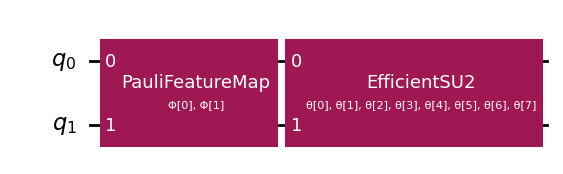

In [15]:
# Definition of the circuit:
# We need a Feature map to encode the data, an Ansatz to train and a observable to evaluate

# Construct feature map (module to transform the data to feature space), ansatz, and optimizer

feature_dim = 2 # Number of qubits in the circuit

feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1, entanglement='linear', paulis = ['X'],parameter_prefix='Φ')
# Linear: entangles each qubit with the next.
# Reps: repetitions of this transformation.
#feature_map.draw()

ansatz = EfficientSU2(feature_dim, reps=1)
#ansatz.draw()
# "EfficientSU2 consists of layers of single qubit operations spanned by SU(2) and CX entanglements".

seed = 10599
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

circuit = feature_map.compose(ansatz) # Putting the circuit together.
circuit.draw('mpl',style='iqx')

In [16]:
# Construct operator for measurement of expectation value of the final model circuit.

expectation = StateFn(circuit, is_measurement=True) @ StateFn(ansatz)

In [17]:
# Construct [toy] loss function

def loss_function(weight,observable):
    loss = np.sum([weight*observable], initial=range_min)
    return loss

In [18]:
# Let's get the gradient:

shifter = Gradient()